## Calcul de l'attention (avec numpy)

In [9]:
import numpy as np
import pandas as pd
import time
import math
from math import sqrt
from scipy.stats import t as student_t
import matplotlib.pyplot as plt

In [2]:
# ------------------------
# Fonction d'attention (inchangée)
# ------------------------
def softmax(x):
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return e_x / e_x.sum(axis=-1, keepdims=True)

def run_attention_once_np(x, block_size):
    seq_len, d_model = x.shape
    output = np.zeros_like(x)
    for i in range(0, seq_len, block_size):
        end = min(i + block_size, seq_len)
        Q = x[i:end]
        K = x[i:end]
        V = x[i:end]
        scores = np.matmul(Q, K.T) / np.sqrt(d_model)
        weights = softmax(scores)
        output[i:end] = np.matmul(weights, V)
    return output


# ------------------------
# Mesure de temps
# ------------------------
def measure_time(x, block_size):
    start = time.perf_counter()
    _ = run_attention_once_np(x, block_size)
    return time.perf_counter() - start

## Grille exhaustive qui teste toutes les combinaisons

* Mesure initiale : pour chaque block_size, effectue initial_repeats mesures et stocke les temps.

* Choix du candidat : identifie le bloc dont la moyenne des temps initiaux est la plus faible.

* Échauffement : relance 5 mesures supplémentaires sur ce “best” pour estimer son intervalle de confiance (IC) à 95 % (Student-t).

* Itération : jusqu’à max_iter, répète :

* Recalcule la moyenne, l’écart-type et l’IC supérieur du “best”.

* Sélectionne tous les blocs dont la moyenne courante ≤ IC supérieur.

* Mesure chacun de ces candidats une fois de plus.

* Met à jour le “best” en choisissant, parmi les candidats, celui à la plus petite moyenne.

* Test de confiance : pour chaque autre bloc, effectue un test t de Welch contre le “best” et calcule la p-value unilatérale.

* Arrêt : dès que toutes les p-values sont < 0.05 (95 % de confiance que le “best” est plus rapide), on sort.

* Résultat : retourne la taille de bloc optimale, toutes les mesures accumulées, et le nombre total de tests effectués.

In [ ]:
# ------------------------
# Grille exhaustive jusqu'à confiance 95%, avec free runs + p_history
# ------------------------
def exhaustive_grid_until_confidence(
    x,
    block_sizes,
    initial_repeats=2,
    free_runs=1,
    confidence=0.95,
    max_iter=100,
    verbose=True
):
    alpha = 1 - confidence
    block_sizes = sorted(set(block_sizes))
    results = {b: [] for b in block_sizes}

    # Pour les tracés
    best_track = []             # meilleur par itération
    best_measurements = []      # tuples (mesure_index, best_block, time_s)
    p_history = []              # liste de dict {bloc: p_value}
    measure_counter = 0         # compteur global de mesures

    # (0) Free runs pour chauffer les caches / JIT
    if free_runs > 0 and verbose:
        print(f"⚙️  Phase 0 : {free_runs} free runs")
    for _ in range(free_runs):
        for b in block_sizes:
            run_attention_once_np(x, b)
    if verbose and free_runs > 0:
        print("Fin des free runs\n")

    # Phase initiale
    if verbose:
        print("🔍 Phase 1 : mesures initiales")
    for b in block_sizes:
        for _ in range(initial_repeats):
            t = measure_time(x, b)
            measure_counter += 1
            results[b].append(t)
        med = np.median(results[b])
        if verbose:
            print(f"Bloc {b:<4} → médiane init : {med:.5f} s")
    total_tests = initial_repeats * len(block_sizes)

    # Boucle d'itérations
    for it in range(1, max_iter+1):
        if verbose:
            print(f"\n🔁 Itération {it} : mesure de tous les blocs")

        # Mesures
        for b in block_sizes:
            t = measure_time(x, b)
            measure_counter += 1
            results[b].append(t)
            if verbose:
                print(f" Bloc {b:<4} → {t:.5f} s (n={len(results[b])})")

        total_tests += len(block_sizes)

        # Moyennes et variances
        means = {b: np.mean(results[b]) for b in block_sizes}
        vars_  = {b: np.var(results[b], ddof=1) for b in block_sizes}
        ns     = {b: len(results[b]) for b in block_sizes}

        # Choix du best
        best = min(means, key=means.get)
        best_track.append(best)
        if verbose:
            print(f" Meilleur moyen actuel : Bloc {best} (mean={means[best]:.5f})")
        best_measurements.append(
            (measure_counter - (len(block_sizes)-block_sizes.index(best)),
             best,
             results[best][-1])
        )

        # Test de confiance pair à pair et enregistrement p-values
        all_confident = True
        p_vals = {}
        for b in block_sizes:
            if b == best:
                continue
            diff     = means[b] - means[best]
            var_diff = vars_[b]/ns[b] + vars_[best]/ns[best]
            t_stat   = diff / math.sqrt(var_diff)
            df = (var_diff**2) / (
                (vars_[b]**2)/(ns[b]**2*(ns[b]-1)) +
                (vars_[best]**2)/(ns[best]**2*(ns[best]-1))
            )
            p_value = 1 - student_t.cdf(t_stat, df)
            p_vals[b] = p_value
            if verbose:
                print(f"  -> Bloc {best} vs Bloc {b}: p={p_value:.4f}")
            if p_value >= alpha:
                all_confident = False

        p_history.append(p_vals)

        if all_confident:
            if verbose:
                print("\n✅ Confiance 95% atteinte pour le meilleur bloc.")
            break

        if it == max_iter and verbose:
            print(f"\n❌ L’algorithme n’a convergé pour aucune taille de bloc avec une confiance de {confidence*100:.0f} %.")

    if verbose and it < max_iter:
        print(f"\n✅ Résultat final : Bloc {best}, tests totaux = {total_tests}")

    return best, results, total_tests, best_track, best_measurements, p_history

In [25]:
# ------------------------
# Exécution
# ------------------------
seq_len, d_model = 2048, 64
x = np.random.randn(seq_len, d_model)
min_size, max_size, step = 32, 512, 32
blocks = list(range(min_size, max_size, step))

best, results, total_tests, best_track, best_meas, p_hist = \
        exhaustive_grid_until_confidence(
            x, blocks,
            initial_repeats=2,
            free_runs=1,
            confidence=0.95,
            max_iter=100,
            verbose=True
        )


⚙️  Phase 0 : 1 free runs
Fin des free runs

🔍 Phase 1 : mesures initiales
Bloc 32   → médiane init : 0.00510 s
Bloc 64   → médiane init : 0.00496 s
Bloc 96   → médiane init : 0.00457 s
Bloc 128  → médiane init : 0.03503 s
Bloc 160  → médiane init : 0.00603 s
Bloc 192  → médiane init : 0.00673 s
Bloc 224  → médiane init : 0.00775 s
Bloc 256  → médiane init : 0.03017 s
Bloc 288  → médiane init : 0.00916 s
Bloc 320  → médiane init : 0.01032 s
Bloc 352  → médiane init : 0.02590 s
Bloc 384  → médiane init : 0.01189 s
Bloc 416  → médiane init : 0.03829 s
Bloc 448  → médiane init : 0.01293 s
Bloc 480  → médiane init : 0.04452 s

🔁 Itération 1 : mesure de tous les blocs
 Bloc 32   → 0.00449 s (n=3)
 Bloc 64   → 0.00457 s (n=3)
 Bloc 96   → 0.00514 s (n=3)
 Bloc 128  → 0.06514 s (n=3)
 Bloc 160  → 0.00870 s (n=3)
 Bloc 192  → 0.00684 s (n=3)
 Bloc 224  → 0.00730 s (n=3)
 Bloc 256  → 0.00821 s (n=3)
 Bloc 288  → 0.06796 s (n=3)
 Bloc 320  → 0.01150 s (n=3)
 Bloc 352  → 0.00965 s (n=3)
 Bloc 384

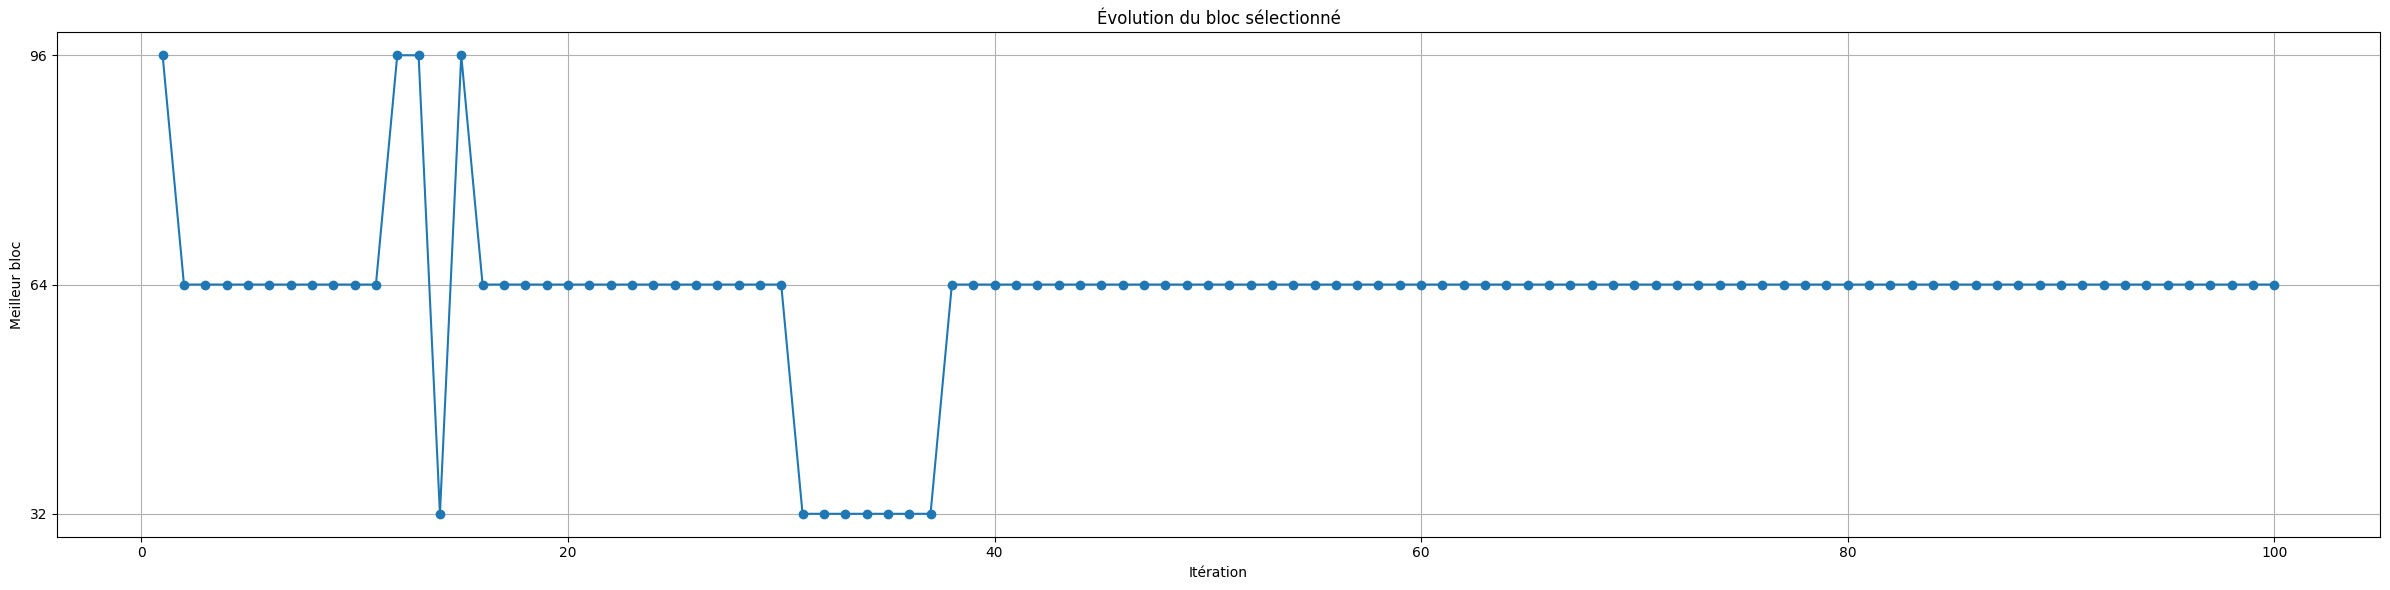

/tmp/ipykernel_60677/2830853949.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([results[b] for b in blocks],


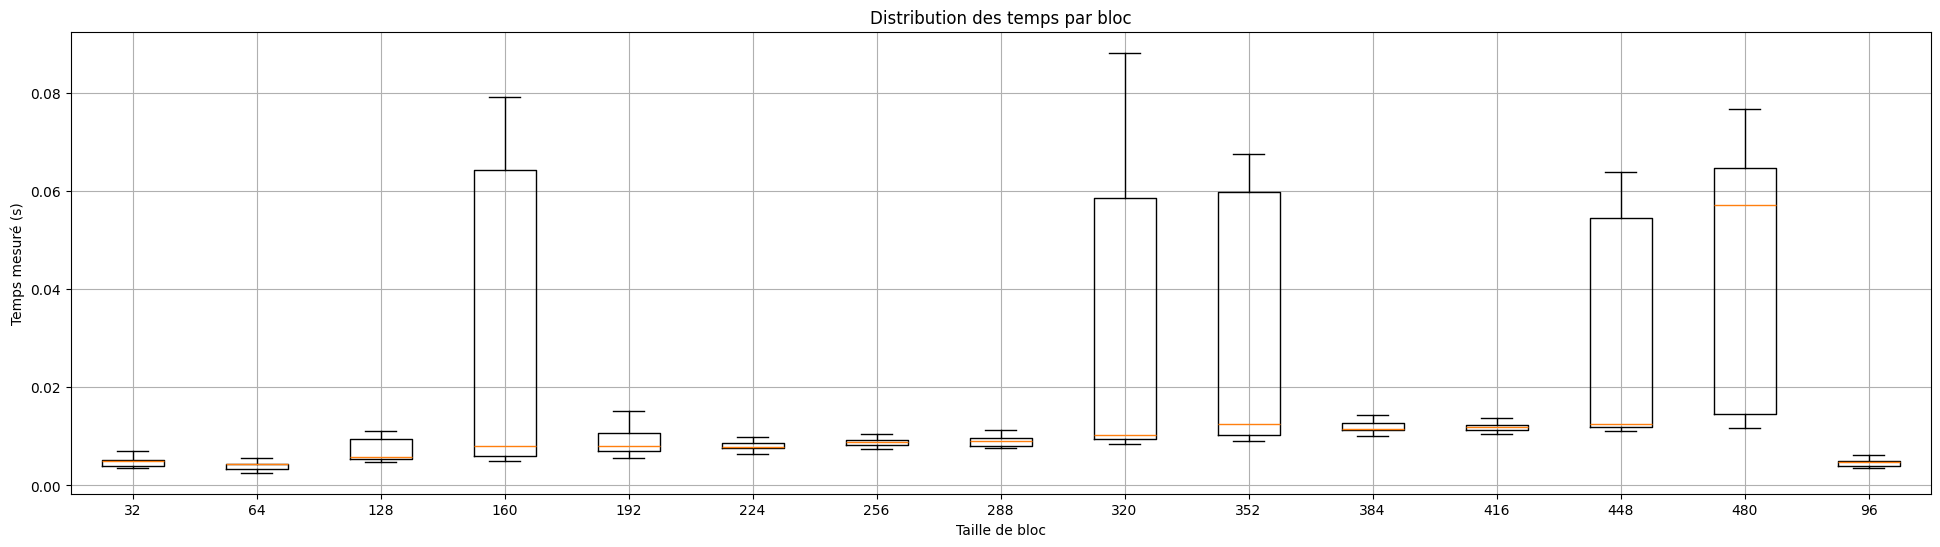

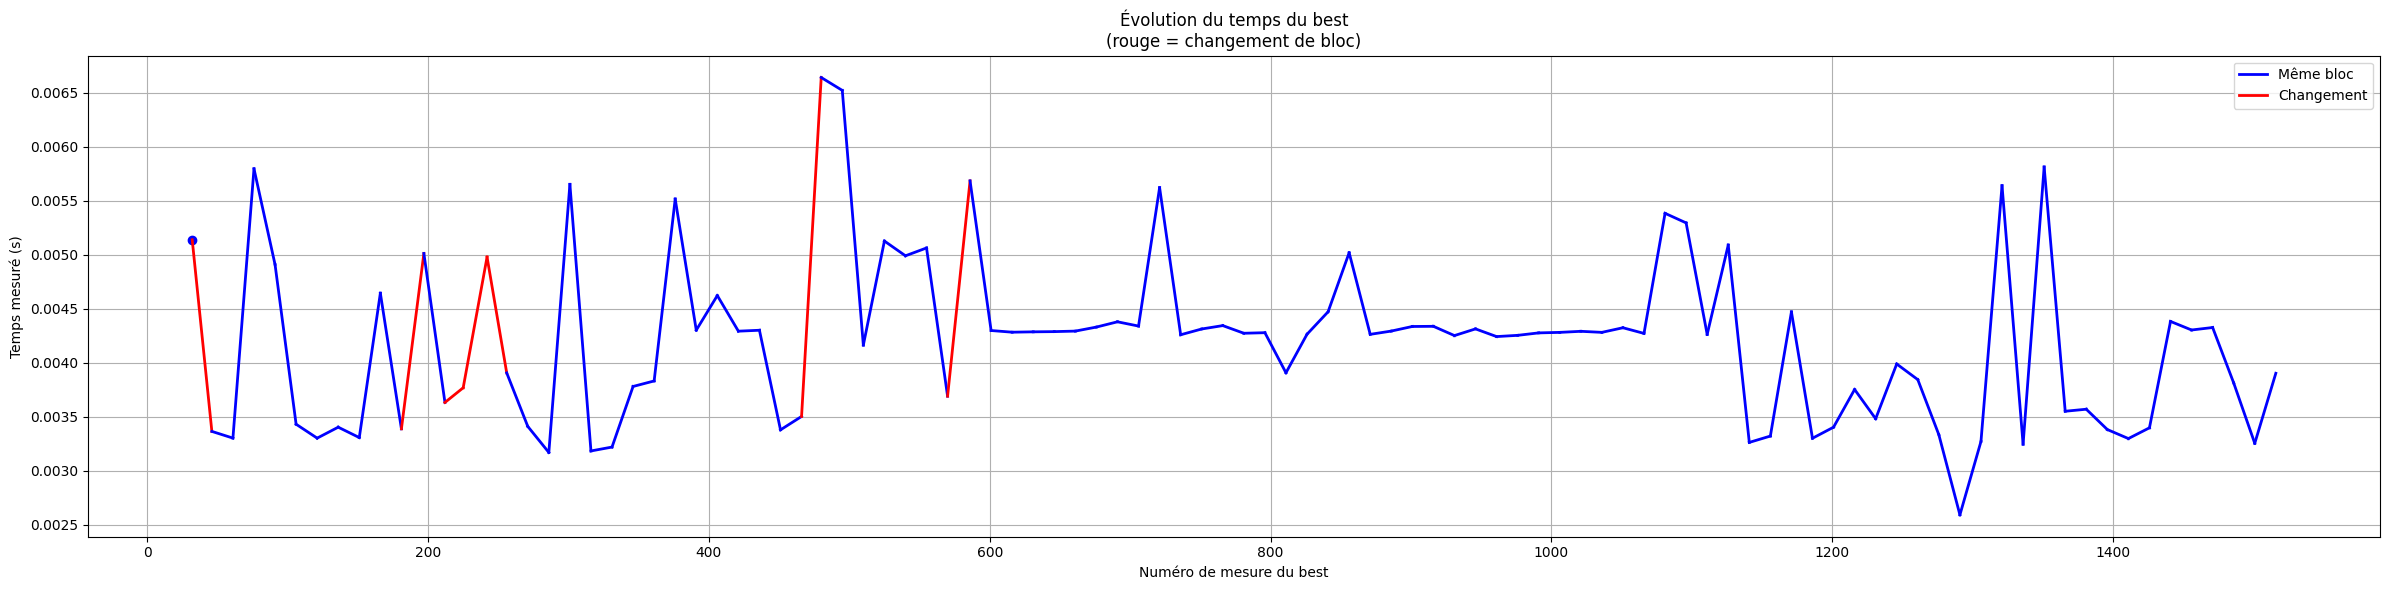

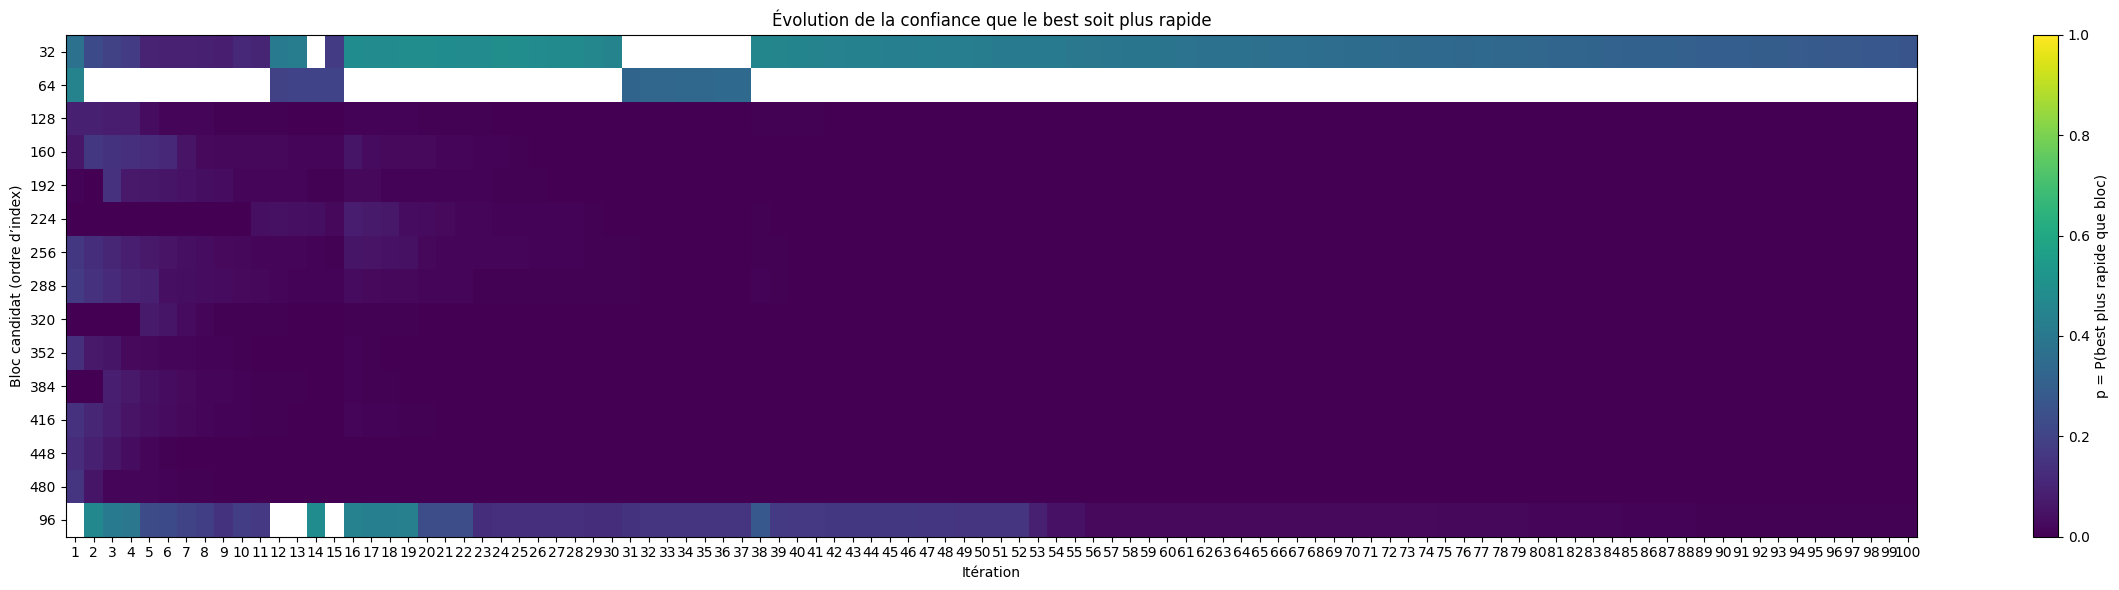

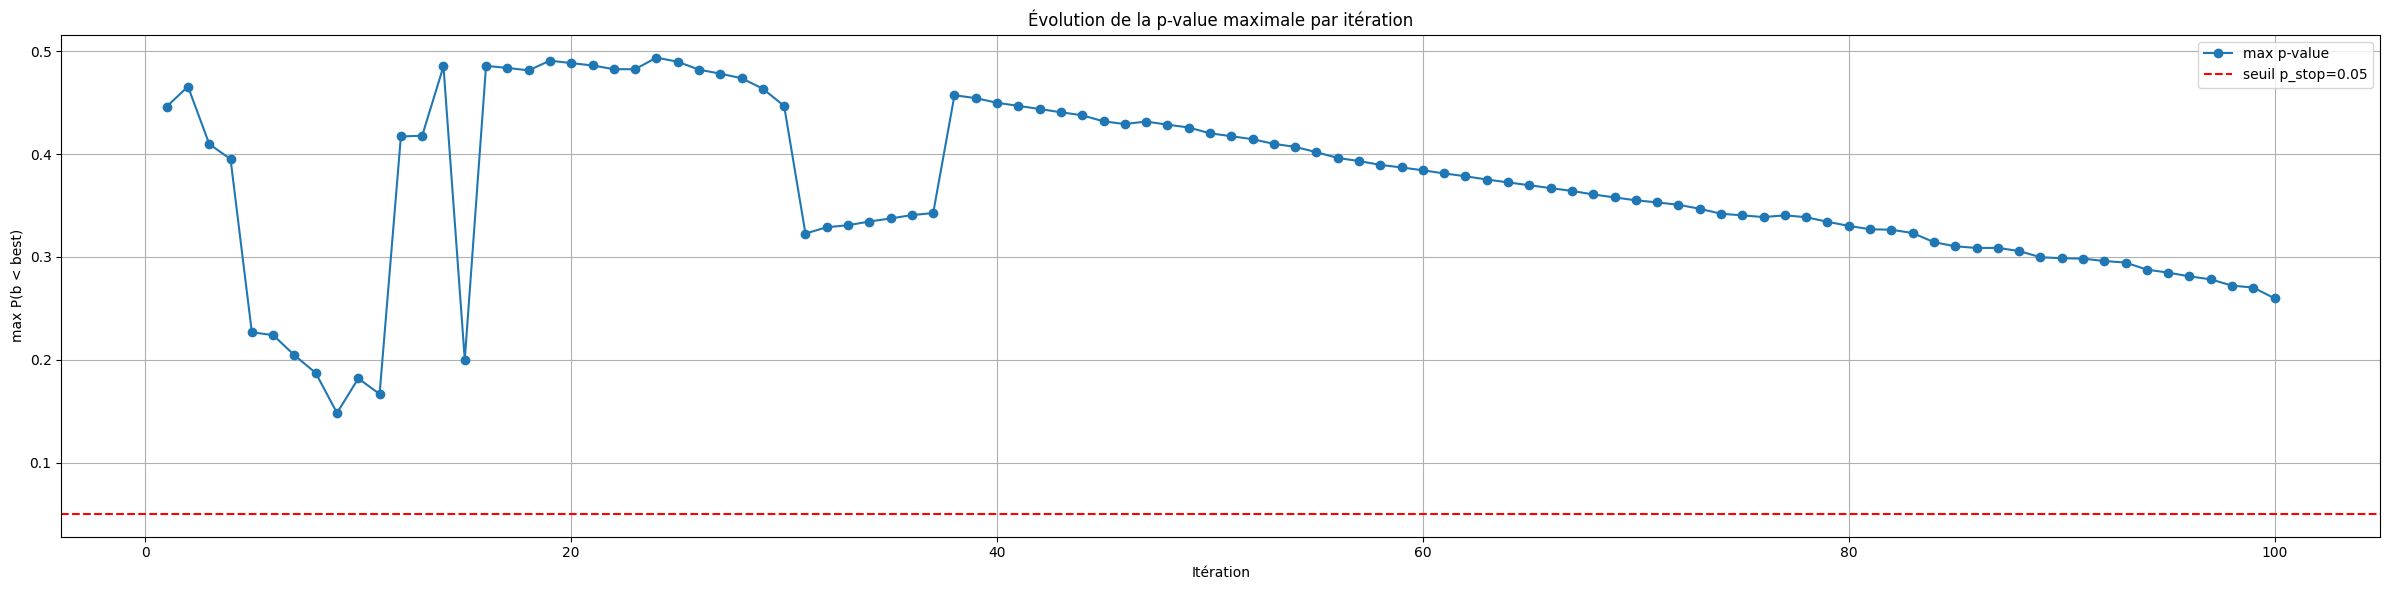

In [27]:
from matplotlib.ticker import MultipleLocator


figsize = (24, 6)
# 1) Évolution du best par itération
fig, ax = plt.subplots(figsize=figsize)
iterations = list(range(1, len(best_track) + 1))

ax.plot(iterations, best_track, marker='o')
ax.set_xlabel("Itération")
ax.set_ylabel("Meilleur bloc")
ax.set_title("Évolution du bloc sélectionné")
ax.grid(True)
ax.yaxis.set_major_locator(MultipleLocator(step))   # un tick par itération
plt.tight_layout()
plt.show()


# 2) Distribution des temps par bloc
plt.figure(figsize=figsize)
plt.boxplot([results[b] for b in blocks],
            labels=[str(b) for b in blocks],
            showfliers=False)
plt.xlabel("Taille de bloc")
plt.ylabel("Temps mesuré (s)")
plt.title("Distribution des temps par bloc")
plt.grid(True)

# 3) Temps du best à chaque mesure, coloré aux changements
indices = [idx for idx, _, _ in best_meas]
blocks_seq = [bsz for _, bsz, _ in best_meas]
times_seq  = [t   for _, _, t in best_meas]
colors = ['red' if curr!=prev else 'blue'
            for prev, curr in zip(blocks_seq, blocks_seq[1:])]

plt.figure(figsize=figsize)
for i in range(len(times_seq)-1):
    plt.plot([indices[i], indices[i+1]],
                [times_seq[i], times_seq[i+1]],
                color=colors[i], linewidth=2)
plt.scatter(indices[0], times_seq[0], color='blue')
plt.xlabel("Numéro de mesure du best")
plt.ylabel("Temps mesuré (s)")
plt.title("Évolution du temps du best\n(rouge = changement de bloc)")
plt.grid(True)
plt.legend([
    plt.Line2D([0],[0], color='blue', lw=2),
    plt.Line2D([0],[0], color='red',  lw=2)
], ["Même bloc", "Changement"])
plt.tight_layout()
plt.show()

# 4) Heatmap de confiance
p_df = pd.DataFrame(p_hist)             # colonnes = blocs dans l’ordre original
blocks = list(p_df.columns)                # on récupère cet ordre

plt.figure(figsize=(24, 6))
plt.imshow(
    p_df.T.values,            # matrice blocs × itérations
    aspect='auto',
    origin='upper',           # ligne index 0 (bloc blocks[0]) tout en haut
    interpolation='nearest',
    cmap='viridis',
    vmin=0, vmax=1
)
plt.colorbar(label="p = P(best plus rapide que bloc)")
# lignes = blocs dans l’ordre de `blocks`
plt.yticks(np.arange(len(blocks)), blocks)
# colonnes = itérations de 1 à N
plt.xticks(np.arange(len(p_df.index)), np.arange(1, len(p_df.index)+1))
plt.xlabel("Itération")
plt.ylabel("Bloc candidat (ordre d’index)")
plt.title("Évolution de la confiance que le best soit plus rapide")
plt.tight_layout()
plt.show()


# 5) Heatmap de confiance
p_max = [max(d.values()) if d else 0.0 for d in p_hist]

# 2) Tracer l’évolution de cette p‐value
fig, ax = plt.subplots(figsize=(24, 6))
iterations = list(range(1, len(p_max) + 1))

ax.plot(iterations, p_max, marker='o', label="max p-value")
ax.axhline(0.05, color='red', linestyle='--', label="seuil p_stop=0.05")

ax.set_xlabel("Itération")
ax.set_ylabel("max P(b < best)")
ax.set_title("Évolution de la p-value maximale par itération")
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()

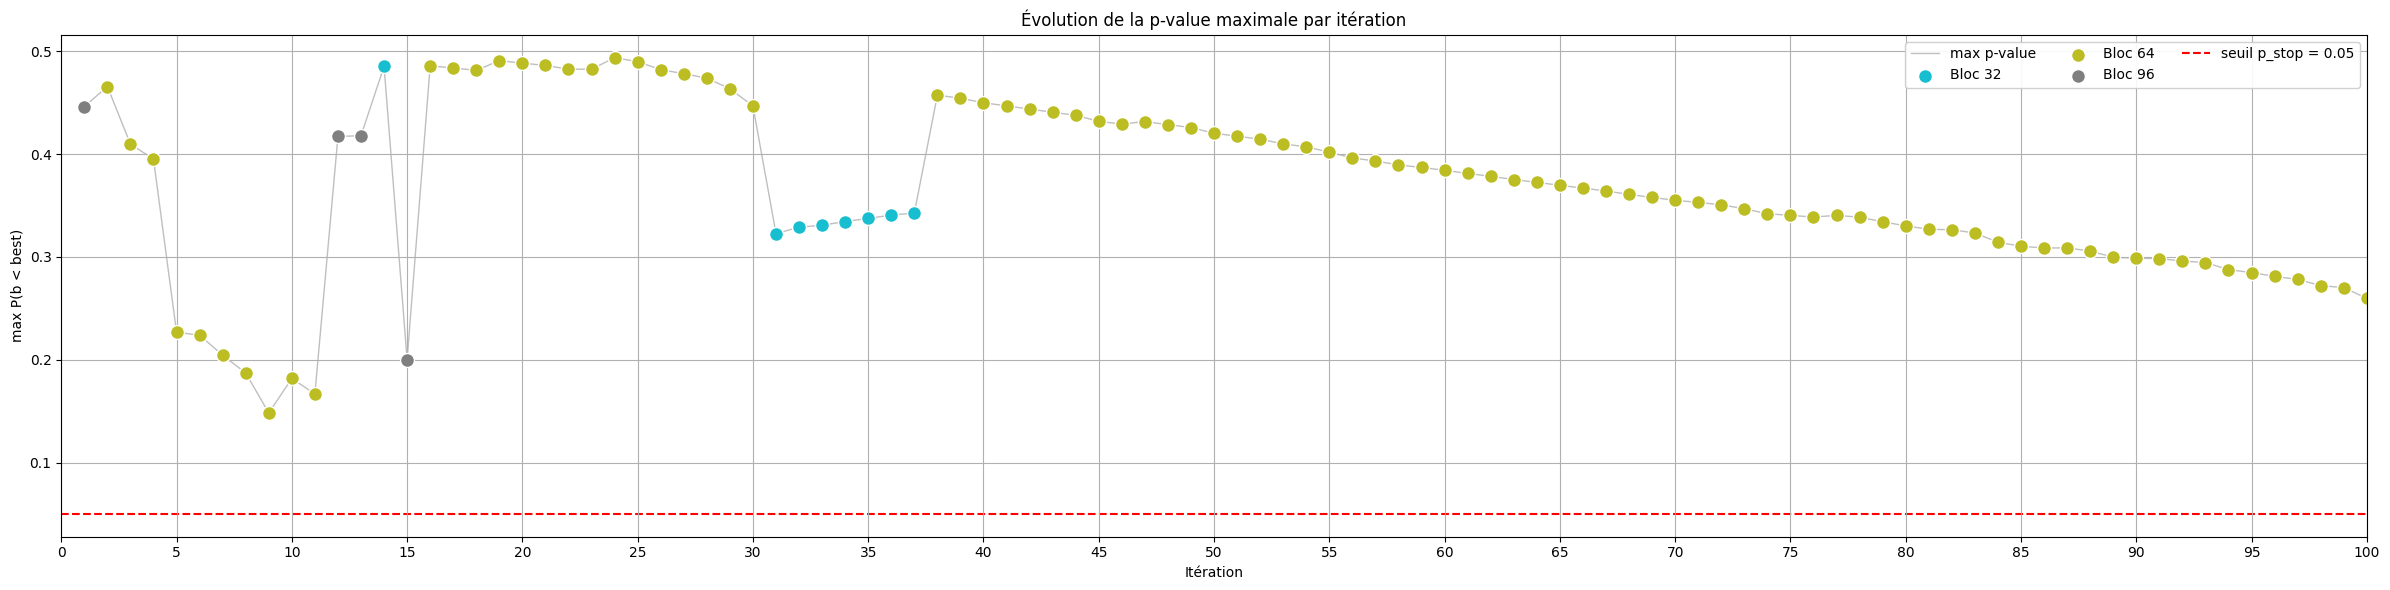

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# best_track et p_max déjà définis
iterations = np.arange(1, len(p_max) + 1)

# Palette simple pour les blocs
unique_blocks = sorted(set(best_track))
cmap = plt.cm.tab10_r
color_map = {b: cmap(i % 10) for i, b in enumerate(unique_blocks)}

fig, ax = plt.subplots(figsize=(24, 6))

# 1) Courbe p_max en gris clair, fine et transparente, zorder=1
ax.plot(iterations, p_max,
        color='gray',
        linestyle='-',
        linewidth=1,
        alpha=0.5,
        zorder=1,
        label='max p-value')

# 2) Points colorés par bloc, zorder=2
for b in unique_blocks:
    xs = [i+1 for i, bb in enumerate(best_track) if bb == b]
    ys = [p_max[i] for i, bb in enumerate(best_track) if bb == b]
    ax.scatter(xs, ys,
               color=color_map[b],
               edgecolor='white',
               s=100,
               zorder=2,
               label=f'Bloc {b}')

# 3) Seuil p_stop en rouge, zorder=0
ax.axhline(0.05,
           color='red',
           linestyle='--',
           linewidth=1.5,
           zorder=0,
           label='seuil p_stop = 0.05')

# Mise en forme
ax.set_xlim(0, len(p_max))
ax.set_xlabel("Itération")
ax.set_ylabel("max P(b < best)")
ax.set_title("Évolution de la p-value maximale par itération")
ax.grid(True)

# Graduations à chaque itération
ax.xaxis.set_major_locator(MultipleLocator(5))

# Légende sans doublons
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(),
          by_label.keys(),
          ncol=3,
          loc='upper right',
          framealpha=0.9)

plt.tight_layout()
plt.show()

NameError: name 'hist' is not defined

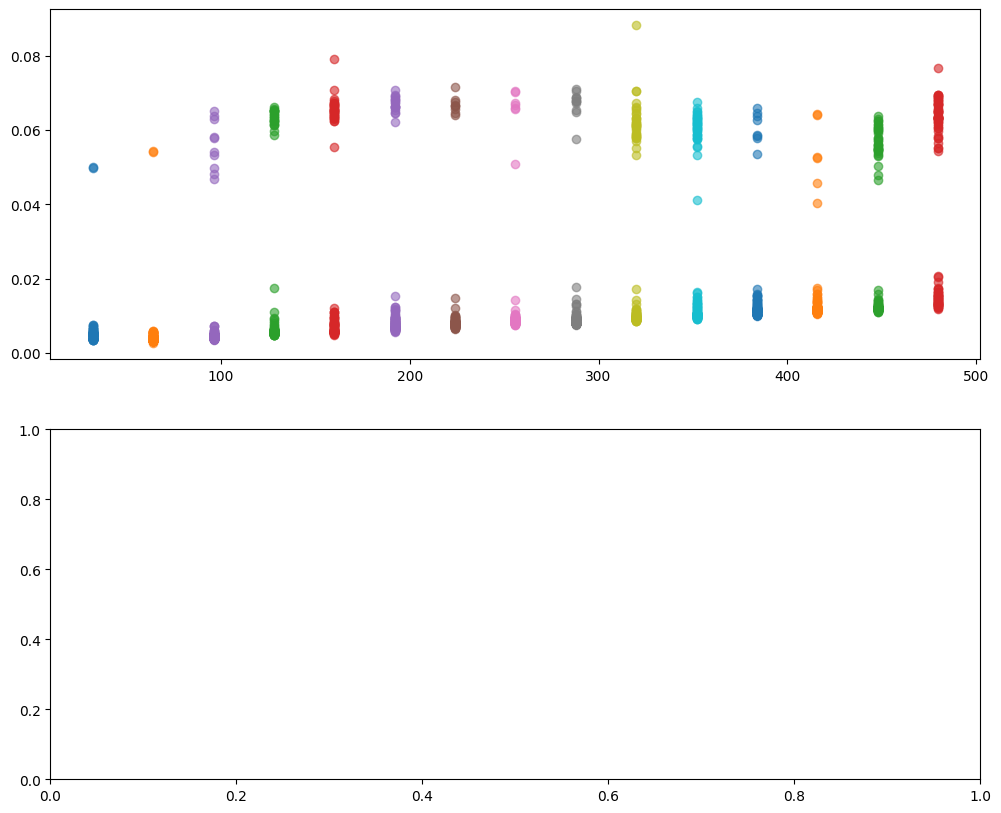

In [39]:
# Tracé
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=False)

# --- HAUT : nuage de points de tous les temps + IC best par itération ---
# On positionne chaque point selon son bloc (axe x=bloc, axe y=temps)
for b in blocks:
    y = results[b]
    x_b = [b] * len(y)
    axes[0].scatter(x_b, y, label=f"Bloc {b}", alpha=0.6)
# Ajout de l'évolution de l'IC du bloc best
ic_means = []
ic_uppers = []
ic_locs = []
for i, (iteration, bestb, m, s, ci_upper) in enumerate(hist):
    ic_means.append(m)
    ic_uppers.append(ci_upper)
    ic_locs.append(bestb)
    axes[0].errorbar(bestb, m, yerr=[[0], [ci_upper - m]], fmt='o', color='black', capsize=5, lw=2, label='IC best' if i==0 else "")

# On force les graduations de l'axe x sur les blocs testés
axes[0].set_xticks(list(blocks))
axes[0].set_xticklabels([str(b) for b in blocks], rotation=45, ha="right")

axes[0].set_title("Temps de calcul pour chaque bloc (nuage de points) et IC du best")
axes[0].set_xlabel("Taille de bloc")
axes[0].set_ylabel("Temps (s)")
if len(blocks) < 20:
    axes[0].set_xticks(list(blocks))
    axes[0].legend()
axes[0].grid(True)

# --- BAS : évolution de la moyenne et de l'IC du best ---
iterations = [h[0] for h in hist]
axes[1].plot(iterations, ic_means, marker='o', label='Moyenne best')
axes[1].plot(iterations, ic_uppers, marker='s', label='CI supérieur')
axes[1].fill_between(iterations, ic_means, ic_uppers, color='orange', alpha=0.3, label='IC best')
axes[1].set_xlabel("Itération")
axes[1].set_ylabel("Temps (s)")
axes[1].set_title("Évolution de la moyenne et de l'IC du best")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Meilleur Benchmark

In [ ]:
# -*- coding: utf-8 -*-
"""
Benchmark adaptatif jusqu'à décision probabiliste,
avec traçage des performances.
"""

from math import sqrt
import numpy as np
from scipy.stats import t as student_t
import matplotlib.pyplot as plt

def _prob_b_faster_than_a(mean_a, std_a, n_a, mean_b, std_b, n_b):
    var = (std_a ** 2) / n_a + (std_b ** 2) / n_b
    if var == 0:
        return 0.5
    se = sqrt(var)
    diff = mean_b - mean_a
    t_stat = diff / se
    df = var**2 / (
        (std_a**4) / (n_a**2 * (n_a - 1)) +
        (std_b**4) / (n_b**2 * (n_b - 1))
    )
    return student_t.cdf(-t_stat, df)


def smart_benchmark_probabilistic(
    x,
    block_sizes,
    *,
    p_switch: float         = 0.50,
    initial_repeats: int    = 2,
    confidence: float       = 0.95,
    free_runs: int          = 1,
    extra_repeats_best: int = 1,
    max_iter: int           = 10,
    verbose: bool           = True,
):
    # ---------------------------------------------------------------
    # Préparation
    # ---------------------------------------------------------------
    block_sizes = sorted(set(block_sizes))
    results = {b: [] for b in block_sizes}
    history = []          # [ (iter, best, {b: p_better}) ]
    best_track = []       # suivi du best
    p_stop = 1 - confidence

    # Pour le troisième graphique :
    best_measurements = []            # liste de tuples (idx, best, t)
    global_measure_counter = 0        # compteur de mesures best

    # (1) réchauffe-caches
    if free_runs > 0 and verbose:
        print(f"⚙️  Phase 0 : {free_runs} free runs")
    for _ in range(free_runs):
        for b in block_sizes:
            run_attention_once_np(x, b)
    if verbose:
        print("Fin des free runs\n")

    # (2) mesures initiales
    if verbose:
        print("🔍 Phase 1 : mesures initiales")
    for b in block_sizes:
        for _ in range(initial_repeats):
            results[b].append(measure_time(x, b))
        if verbose:
            print(f"Bloc {b:<4} → {np.mean(results[b]):.5f} s (n={len(results[b])})")

    # (3) best initial + répétitions bonus
    best = min(block_sizes, key=lambda b: np.mean(results[b]))
    if verbose:
        print(f"\nBest initial : {best}")
    for _ in range(extra_repeats_best):
        t = measure_time(x, best)
        # enregistrement pour graphique 3
        global_measure_counter += 1
        best_measurements.append((global_measure_counter, best, t))
        results[best].append(t)

    # ---------------------------------------------------------------
    # Boucle principale
    # ---------------------------------------------------------------
    for it in range(1, max_iter + 1):
        # Stats de tous les blocs
        stats = {
            b: (
                np.mean(results[b]),
                np.std(results[b], ddof=1) if len(results[b]) > 1 else 0.0,
                len(results[b]),
            )
            for b in block_sizes
        }
        mean_best, std_best, n_best = stats[best]

        # Probabilités P(b < best)
        p_better = {}
        for b in block_sizes:
            if b == best:
                continue
            mean_b, std_b, n_b = stats[b]
            p_better[b] = _prob_b_faster_than_a(
                mean_best, std_best, n_best,
                mean_b, std_b, n_b
            )

        history.append((it, best, p_better.copy()))
        best_track.append(best)

        if verbose:
            print(f"\n🔁 Itération {it}: best = {best}")
            for b, p in sorted(p_better.items()):
                print(f"  P({b} plus rapide que {best}) = {p:.3f}")

        # Décision : stop ? switch ?
        max_p = max(p_better.values(), default=0.0)
        if max_p < p_stop:
            if verbose:
                print(f"\n✅ Arrêt, toutes proba < {p_stop:.2f}")
            break

        if max_p > p_switch:
            new_best = max(p_better, key=p_better.get)
            if verbose:
                print(f"↪️ Switch : {best} → {new_best} (p={max_p:.3f})")
            best = new_best

        # Sélection des blocs à remesurer
        to_measure = [best] + [b for b, p in p_better.items() if p >= p_stop]
        if verbose:
            print("Mesures supplémentaires :", to_measure)

        for b in to_measure:
            t = measure_time(x, b)
            # n’enregistrer que si c’est le best
            if b == best:
                global_measure_counter += 1
                best_measurements.append((global_measure_counter, best, t))
            results[b].append(t)
            if verbose:
                print(f"  Bloc {b:<4} → {t:.5f} s (n={len(results[b])})")
        
        if it == max_iter:
            print(f"\n❌ L’algorithme n’a convergé pour aucune taille de bloc avec une confiance de {confidence*100:.0f} %.")

    # Résultat final
    if verbose:
        m_final = float(np.median(results[best]))
        tot = sum(len(v) for v in results.values())
        print(f"\n🏁 Best final : {best} (médiane={m_final:.5f} s), mesures={tot}")
        

    return best, results, history, best_track, best_measurements


In [ ]:
# ------------------------
# Exécution
# ------------------------
seq_len, d_model = 2048, 64
x = np.random.randn(seq_len, d_model)
blocks = list(range(0, 512, 16))

best, results, history, best_blocks_by_iter, best_measurements = \
    smart_benchmark_probabilistic(
        x, blocks,
        initial_repeats    = 2,
        free_runs          = 1,
        extra_repeats_best = 0,
        verbose            = True
    )

NameError: name 'run_attention_once' is not defined

/tmp/ipykernel_43280/1544241572.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


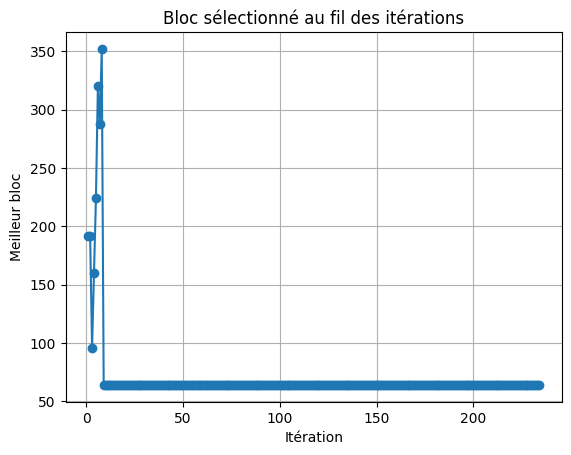

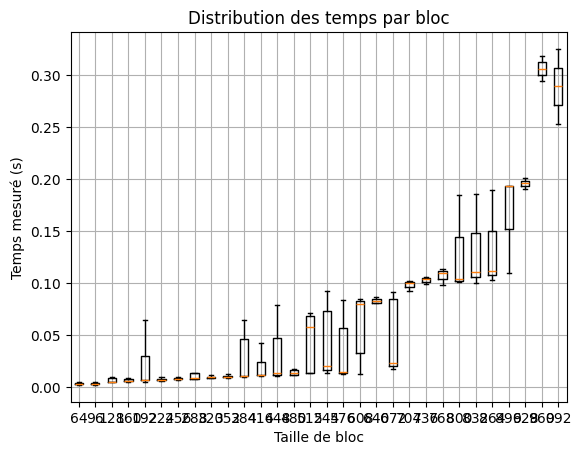

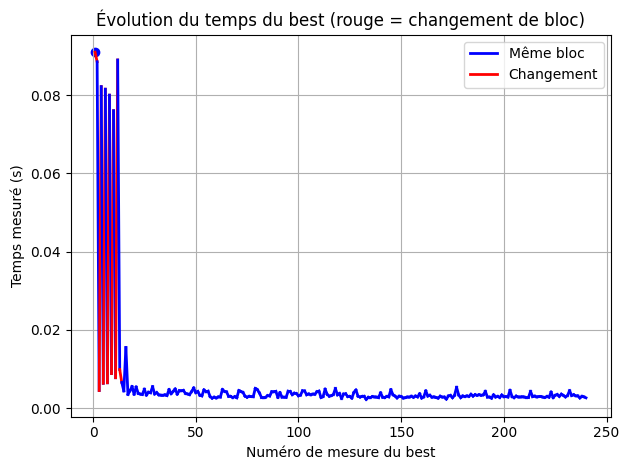

In [ ]:
# ------------------------
# Tracés
# ------------------------

# 1) Évolution du bloc sélectionné par itération
plt.figure()
plt.plot(
    range(1, len(best_blocks_by_iter) + 1),
    best_blocks_by_iter,
    marker='o'
)
plt.xlabel("Itération")
plt.ylabel("Meilleur bloc")
plt.title("Bloc sélectionné au fil des itérations")
plt.grid(True)

# 2) Distribution des temps par bloc
plt.figure()
plt.boxplot(
    [results[b] for b in blocks],
    labels=[str(b) for b in blocks],
    showfliers=False
)
plt.xlabel("Taille de bloc")
plt.ylabel("Temps mesuré (s)")
plt.title("Distribution des temps par bloc")
plt.grid(True)

# 3) Temps du best à chaque mesure, segments colorés
# Préparation des données
indices = [idx for idx, _, _ in best_measurements]
blocks_seq = [bsz for _, bsz, _ in best_measurements]
times_seq  = [t   for _, _, t in best_measurements]
# Couleurs : rouge si changement de best, bleu sinon
colors = [
    'red' if curr != prev else 'blue'
    for prev, curr in zip(blocks_seq, blocks_seq[1:])
]
# Tracé segment par segment
plt.figure()
for i in range(len(times_seq)-1):
    plt.plot(
        [indices[i], indices[i+1]],
        [times_seq[i], times_seq[i+1]],
        color=colors[i],
        linewidth=2
    )
# Premier point
plt.scatter(indices[0], times_seq[0], color='blue')
plt.xlabel("Numéro de mesure du best")
plt.ylabel("Temps mesuré (s)")
plt.title("Évolution du temps du best (rouge = changement de bloc)")
plt.grid(True)
plt.legend([
    plt.Line2D([0],[0], color='blue', lw=2),
    plt.Line2D([0],[0], color='red',  lw=2)
], ["Même bloc", "Changement"])
plt.tight_layout()
plt.show()